In [3]:
import pandas as pd
import numpy as np
# This file contains all required utilities to build resolvings sets and probabilistic methods
from Utils.resolving import *
from Utils.dataframes import *
from Utils.SVM  import SVC_model
from Utils.plots import averaging_plot

# import os
## Figure out file path. Better for working with people
#root_path = os.path.dirname(___file__); 

SENTI_DATA_PATH= "../Files/Full_Vader_Senti.txt"

### Cross Contamination Sentence Generating Function

In [4]:
#addition of cross contamination 
#############################################
#
#Param: n := number of words in each dictionary (n for each tone) 
#       lam := average sentence length
#       crossC_fraction := the expected portion of the words in each sentnece that are from the opposite tone.
#
#
#############################################
def generate_cross_contaminated_sentences(n = 350, lam = 50, crossC_fraction = 0.01):
    
    imported_vader_words = []
    negative_vader_list = []
    neutral_vader_list = []
    positive_vader_list = []
    
    #reading in the words. Change the filepath to suit where yours is stored
    x = open(SENTI_DATA_PATH, "r")
    #e = r"C:\Users\ajpar\Desktop\Research Documents\Project Coding\Full_Tweet_List_Processed.txt"
    for line in x:
        
        l = line.strip('\n')
        l = l.split("\t")
        imported_vader_words.append(l)
        
    x.close()

    for y in imported_vader_words : #sorting the words by tone
        if (-1<= float(y[1]) <= 1):
            neutral_vader_list.append(y[0]) 
        elif (float(y[1]) < -1):
            negative_vader_list.append(y[0])
        else :
            positive_vader_list.append(y[0])


    shorten_pos = random.sample(positive_vader_list, n) #gets random n words w/out duplicates
    shorten_neg = random.sample(negative_vader_list, n) #gets random n words w/out duplicates
    shorten_neutral = random.sample(neutral_vader_list, n) #gets random n words w/out duplicates


    negative_sent_list = []
    for i in range(0,500):
        h = np.random.poisson(lam=lam - lam*crossC_fraction, size=None)
        k = np.random.poisson(lam= lam*crossC_fraction, size=None)
        negative_sent_list.append(random.sample(shorten_neg, h) +random.sample(shorten_pos, k))

    positive_sent_list = []
    for i in range(0,500):
        #changes so poisson is still same mean with addition
        h = np.random.poisson(lam=lam - lam*crossC_fraction, size=None)
        k = np.random.poisson(lam= lam*crossC_fraction, size=None)
        positive_sent_list.append(random.sample(shorten_pos, h)+random.sample(shorten_neg, k))


    final_list = negative_sent_list + positive_sent_list

    #getting wordlist 
    wordlist_crossC = {x for l in final_list for x in l}
    wordlist_crossC_prime = {x for l in final_list for x in l}

    #generating resolving set. note that the "prime" is for the compliment resolving set, and can be deleted if you don't want to deal with that
    resolving_crossC = Random_Resolving_Set(wordlist_crossC)
    resolving_crossC_prime = Random_Resolving_Set_Compliment(wordlist_crossC_prime)

    #generating the Jaccard Matrices
    JacMatrix_crossC = JVecEMatrix(resolving_crossC,final_list)
    JacMatrix_crossC_prime = JVecEMatrix(resolving_crossC_prime,final_list)

    labeled_dic_crossC = {}
    labeled_dic_crossC_prime = {}

    #this just stores all the vectors of the Jmatrix in a dictionary with key vec, and tone corresponding to its tone. 
    for i in range(0,len(JacMatrix_crossC)):
        if (i<500):
            labeled_dic_crossC[i] = {'vec': JacMatrix_crossC[i], 'tone': "negative"}
        elif (500<i<1000):
            labeled_dic_crossC[i] = {'vec': JacMatrix_crossC[i], 'tone': "positive"}
        else:
            labeled_dic_crossC[i] = {'vec': JacMatrix_crossC[i], 'tone': "neutral"} #for now this never triggers, but could for tri tone cross contam


    for i in range(0,len(JacMatrix_crossC_prime)):
        if (i<500):
            labeled_dic_crossC_prime[i] = {'vec': JacMatrix_crossC_prime[i], 'tone': "negative"}
        elif (500<i<1000):
            labeled_dic_crossC_prime[i] = {'vec': JacMatrix_crossC_prime[i], 'tone': "positive"}
        else:
            labeled_dic_crossC_prime[i] = {'vec': JacMatrix_crossC_prime[i], 'tone': "neutral"}#for now this never triggers, but could for tri tone cross contam
            
    return Dict_to_df(labeled_dic_crossC); 

## Cross Contamination Averaging Plot

In [5]:
import seaborn as sns

inc_frac = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40]
acc_score = []
for fraction in inc_frac: 
    curr_acc_list = []
    for i in range(10):
        cross_df, tones = generate_cross_contaminated_sentences(crossC_fraction=fraction)
        tones = Category_encode(tones)
        curr_acc_list.append(SVC_model(cross_df, tones))
    acc_score.append(curr_acc_list)

acc = np.array(acc_score).T
accuracy_df = pd.DataFrame(acc, columns=["1%", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%"])

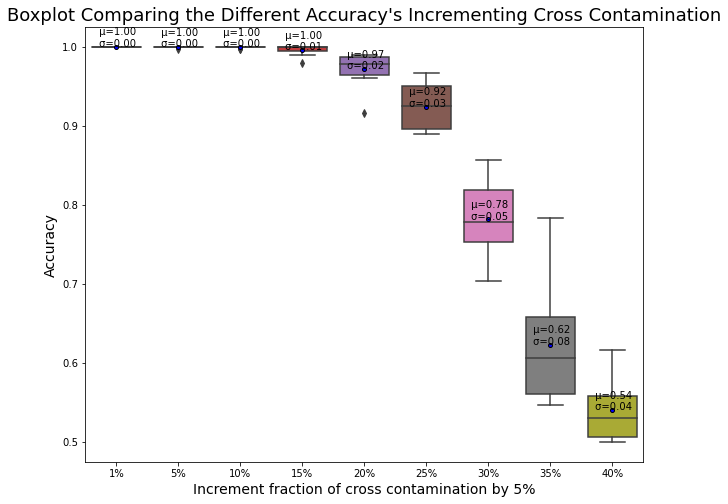

In [6]:
xlabel = "Increment fraction of cross contamination by 5%"
title = "Boxplot Comparing the Different Accuracy's Incrementing Cross Contamination"
averaging_plot(accuracy_df, x_label=xlabel, title=title)